In [1]:
from collections import defaultdict
import inspect
import itertools
import os
import re
import subprocess
import sys

import nltk
from nltk.tokenize import WhitespaceTokenizer
import NERDA
import pandas as pd
import seaborn
import sqlite3

In [2]:
print(os.getcwd())
os.getcwd()
%ls

/Users/kaze7539/proj/bri/newa
README.md
__init__.py
__pycache__/
abe_bigram_naive_bayes_and_maxent.ipynb
abe_simple_naive_bayes.ipynb
conlleval.pl*
exploreNewa.ipynb
for_ml/
good_length.txt
just_ec.conll
ki.txt
ki_true.txt
lined_up.txt
new_dedup.txt
newfile.txt
results.db
run_all_experiments.ipynb
tmp.txt
tmp.txt~
tmp1.txt
tmp1.txt~
util.py
util.py~


In [3]:
sys.path.append(".")
print(sys.path)
import util # library/module with recorded experiments and helper functions

['/Users/kaze7539/proj/bri/newa', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python38.zip', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8', '/usr/local/opt/python@3.8/Frameworks/Python.framework/Versions/3.8/lib/python3.8/lib-dynload', '', '/Users/kaze7539/.virtualenvs/bri/lib/python3.8/site-packages', '/Users/kaze7539/.virtualenvs/bri/lib/python3.8/site-packages/IPython/extensions', '/Users/kaze7539/.ipython', '.']


In [4]:
# here are all the experiments that have been saved in util.py
experiments = sorted([item for item in dir(util) if item.startswith("experiment")])
print(experiments)


['experiment_001_naive_bayes_unigram', 'experiment_002_naive_bayes_pseudo_bigram_dishonest', 'experiment_002_naive_bayes_pseudo_bigram_honest', 'experiment_003_maxent_pseudo_bigram', 'experiment_004_maxent_bigram', 'experiment_005_bri_nerda']


In [5]:
# create a database to store the results
connection = sqlite3.connect("results.db")
cursor = connection.cursor()
cursor.execute('''
    create table if not exists conlleval
    (
      experiment_name text not null,
      num_tokens integer not null,
      num_phrases integer not null,
      num_found integer not null,
      num_correct integer not null,
      accuracy real not null,
      precision real not null,
      recall real not null,
      fb1 real not null,
      constraint conlleval_pk primary key (experiment_name)
    );
    ''')

In [6]:
for experiment in experiments:
    print(experiment)
    cursor.execute("select * from conlleval where experiment_name = ?", (experiment, ))
    results = cursor.fetchone()
    if results: # if you want to rerun all the experiments delete the database file
        print("results cached", results)
    else:
        results = globals()[experiment]()
        cursor.execute("""
            insert into conlleval
            (experiment_name,  num_tokens, num_phrases, num_found, num_correct, accuracy, precision, recall, fb1)
            values (
            :experiment_name,
            :num_tokens,
            :num_phrases,
            :num_found,
            :num_correct,
            :accuracy,
            :precision,
            :recall,
            :fb1
            );
        """, results)
        print(results)
        connection.commit()

experiment_001_naive_bayes_unigram
results cached ('experiment_001_naive_bayes_unigram', 711, 33, 126, 0, 52.88, 0.0, 0.0, 0.0)
experiment_002_naive_bayes_pseudo_bigram_dishonest
results cached ('experiment_002_naive_bayes_pseudo_bigram_dishonest', 711, 33, 40, 21, 97.33, 52.5, 63.64, 57.53)
experiment_002_naive_bayes_pseudo_bigram_honest
results cached ('experiment_002_naive_bayes_pseudo_bigram_honest', 711, 33, 33, 19, 84.39, 57.58, 57.58, 57.58)
experiment_003_maxent_pseudo_bigram
results cached ('experiment_003_maxent_pseudo_bigram', 711, 33, 41, 26, 83.12, 63.41, 78.79, 70.27)
experiment_004_maxent_bigram
results cached ('experiment_004_maxent_bigram', 711, 33, 37, 27, 89.73, 72.97, 81.82, 77.14)
experiment_005_bri_nerda
results cached ('experiment_005_bri_nerda', 242, 13, 16, 10, 96.28, 62.5, 76.92, 68.97)


In [12]:
# read experiment data into pandas dataframe
df = pd.read_sql_query("SELECT * from conlleval", connection)
#print(df.melt.__doc__)

In [8]:
df

,experiment_name,num_tokens,num_phrases,num_found,num_correct,accuracy,precision,recall,fb1
0,experiment_001_naive_bayes_unigram,711,33,126,0,52.88,0.00,0.00,0.00
1,experiment_002_naive_bayes_pseudo_bigram_disho...,711,33,40,21,97.33,52.50,63.64,57.53
2,experiment_002_naive_bayes_pseudo_bigram_honest,711,33,33,19,84.39,57.58,57.58,57.58
3,experiment_003_maxent_pseudo_bigram,711,33,41,26,83.12,63.41,78.79,70.27
4,experiment_004_maxent_bigram,711,33,37,27,89.73,72.97,81.82,77.14
5,experiment_005_bri_nerda,242,13,16,10,96.28,62.50,76.92,68.97


In [9]:
df.melt(id_vars=['experiment_name'], value_vars=["precision", "recall", "fb1"])

,experiment_name,variable,value
0,experiment_001_naive_bayes_unigram,precision,0.00
1,experiment_002_naive_bayes_pseudo_bigram_disho...,precision,52.50
2,experiment_002_naive_bayes_pseudo_bigram_honest,precision,57.58
3,experiment_003_maxent_pseudo_bigram,precision,63.41
4,experiment_004_maxent_bigram,precision,72.97
5,experiment_005_bri_nerda,precision,62.50
6,experiment_001_naive_bayes_unigram,recall,0.00
7,experiment_002_naive_bayes_pseudo_bigram_disho...,recall,63.64
8,experiment_002_naive_bayes_pseudo_bigram_honest,recall,57.58
9,experiment_003_maxent_pseudo_bigram,recall,78.79


In [10]:
import seaborn as sbn

<AxesSubplot:xlabel='value', ylabel='experiment_name'>

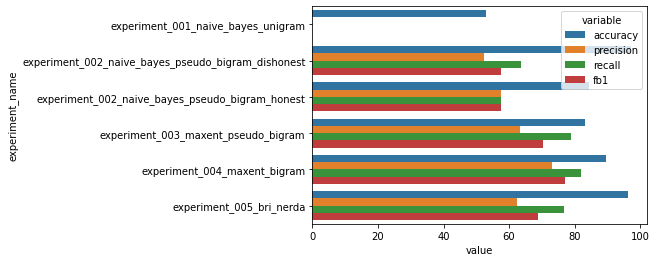

In [11]:
sbn.barplot(
    data=df.melt(id_vars=['experiment_name'], value_vars=["accuracy","precision", "recall", "fb1"]), 
    y="experiment_name", 
    x="value", 
    hue="variable"
)